# Getting data ready to model

In [10]:
import pickle
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression,RidgeCV,Lasso,Ridge,LassoCV
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.linear_model import lars_path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt

In [121]:
# Upload the dataframe that I built in my scraping notebook
with open('../data/schools_updatedData','rb') as read_file:
    school_df = pickle.load(read_file)

## Simplify columns and then make dummy variables

In [122]:
# This column will be a binary value assigned to unionized charters with contracts 
# a 1 is a contract with a contract over 200 days old, a 0 is a very new contract/
school_df['ThreshContract']=(school_df['Days_Cont']>200)
school_df['ThreshContract']=school_df['ThreshContract'].astype(int)

In [123]:
# Drop a lot of redundant categorical variable, like CPS network and SQRPrat
school_df_smaller=school_df[['SQRPpts', 'Type',
       'Ambitious Instruction', 'Collaborative Teachers', 'Effective Leaders',
       'Involved Families', 'Supportive Environment',' Total ', 'Bilingual', 'Sped', 'FRLunch', 
       'Student Attendance Rate', 'Student Mobility Rate',
       'Teacher Retention Rate', 'AvgClassSize',
       'Principal Turnover within 6 Years', 'ThreshContract','UNIONIZED']]

In [124]:
# Refine unionized category to be more specific, clean column headings and make everything more intuitive
schdf1.UNIONIZED = school_df_smaller.UNIONIZED.replace({"NO":"NonUCh",'YES':'UCh'})
schdf1.columns = school_df_smaller.columns.str.strip()
schdf1 = school_df_smaller.rename(columns={'Total':'Population'})


In [127]:
# Get dummy variables for type and unionization statue, drop_first values 
#to avoid collinearity
sch_df= pd.get_dummies(schdf1, drop_first=True)


In [128]:
sch_df.head()

,SQRPpts,Ambitious Instruction,Collaborative Teachers,Effective Leaders,Involved Families,Supportive Environment,Total,Bilingual,Sped,FRLunch,Student Attendance Rate,Student Mobility Rate,Teacher Retention Rate,AvgClassSize,Principal Turnover within 6 Years,ThreshContract,Type_E,Type_H,UNIONIZED_NO,UNIONIZED_YES
SchoolID,,,,,,,,,,,,,,,,,,,,
400033,3.2,41.0,64.0,61.0,47.0,12.0,1288.0,0.010,0.186,0.909,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0
400035,4.0,75.0,60.0,53.0,65.0,53.0,604.0,0.199,0.108,0.887,96.2,8.5,38.7,22.0,1.0,0,0,0,1,0
400036,2.3,57.0,57.0,43.0,60.0,59.0,682.0,0.076,0.136,0.745,88.8,28.6,75.6,24.0,3.0,0,0,0,1,0
400052,3.8,NaN,NaN,NaN,NaN,NaN,1191.0,0.006,0.155,0.867,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0
400061,2.8,69.0,62.0,55.0,44.0,49.0,406.0,0.003,0.185,0.926,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0


## Playing around with NaN values

For the next few cells, I experiment with different ways of handling NA values - since charters underreport certain data, I don't want to drop NaNs and kick all charters out of my data set. I also don't want to oversmooth my data by plugging in median values for charters all over the place.

**NOTE** After dropping NA values, most of the charter schools drop out of the data set, only 5 NonUnionized and 1 Unionized charter remain

In [129]:
sch_df2=sch_df.dropna()
sch_df2.UNIONIZED_NonUCh.value_counts(), sch_df2.UNIONIZED_UCh.value_counts()

AttributeError: 'DataFrame' object has no attribute 'UNIONIZED_NonUCh'

### Let's run a naive model to see if I can remove features that charters underreport 

In [18]:
y = sch_df2['Ambitious Instruction']
x = sch_df2.drop('Ambitious Instruction', axis=1)
sch_df2.columns

Index(['SQRPpts', 'Ambitious Instruction', 'Collaborative Teachers',
       'Effective Leaders', 'Involved Families', 'Supportive Environment',
       'Population', 'Bilingual', 'Sped', 'FRLunch', 'Student Attendance Rate',
       'Student Mobility Rate', 'Teacher Retention Rate', 'AvgClassSize',
       'Principal Turnover within 6 Years', 'ThreshContract', 'Type_E',
       'Type_H', 'UNIONIZED_NonUCh', 'UNIONIZED_UCh'],
      dtype='object')

In [19]:
# Create your model
model = sm.OLS(y, x)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Ambitious Instruction   R-squared (uncentered):                   0.991
Model:                               OLS   Adj. R-squared (uncentered):              0.991
Method:                    Least Squares   F-statistic:                              2557.
Date:                   Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                           15:49:07   Log-Likelihood:                         -1449.5
No. Observations:                    428   AIC:                                      2935.
Df Residuals:                        410   BIC:                                      3008.
Df Model:                             18                                                  
Covariance Type:               nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
SQRPpts                              -0.2086      0.782     -0.267      0.790      -1.746       1.329
Collaborative Teachers                0.1582      0.056      2.847      0.005       0.049       0.267
Effective Leaders                     0.0342      0.055      0.621      0.535      -0.074       0.142
Involved Families                     0.0854      0.043      1.993      0.047       0.001       0.170
Supportive Environment                0.5157      0.026     20.189      0.000       0.465       0.566
Population                            0.0009      0.001      0.791      0.429      -0.001       0.003
Bilingual                           -15.2994      2.529     -6.051      0.000     -20.270     -10.329
Sped                                -12.5027      5.548     -2.254      0.025     -23.409      -1.597
FRLunch                              16.3959      2.735      5.994      0.000      11.019      21.773
Student Attendance Rate               0.2315      0.078      2.972      0.003       0.078       0.385
Student Mobility Rate                 0.0255      0.063      0.405      0.686      -0.098       0.150
Teacher Retention Rate                0.0121      0.053      0.230      0.818      -0.092       0.116
AvgClassSize                         -0.0278      0.048     -0.577      0.564      -0.123       0.067
Principal Turnover within 6 Years    -0.3447      0.345     -1.001      0.318      -1.022       0.333
ThreshContract                     9.057e-15   6.62e-15      1.368      0.172   -3.96e-15    2.21e-14
Type_E                                1.2540      2.512      0.499      0.618      -3.685       6.193
Type_H                               -4.2772      2.305     -1.856      0.064      -8.808       0.254
UNIONIZED_NonUCh                     -7.4209      4.109     -1.806      0.072     -15.497       0.656
UNIONIZED_UCh                        -6.9068      8.335     -0.829      0.408     -23.291       9.478
==============================================================================
Omnibus:                        1.313   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.519   Jarque-Bera (JB):                1.399
Skew:                          -0.103   Prob(JB):                        0.497
Kurtosis:                       2.810   Cond. No.                     4.68e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-33. This might indicate that there are
strong multicollinearity problems or that the design m

### Repull Data -> 
Since Student Mobility, Teacher Retention, Principal Turnover, and Class Size do not have strong impact on that model (and have high NA values for charters), repull the data without those columns. 

In [20]:
#Redo all the cleaning I did on previous dataframe, and recreate dummies
school_df_smaller=school_df[['SQRPpts', 'Type',
       'Ambitious Instruction', 'Collaborative Teachers', 'Effective Leaders',
       'Involved Families','Student Attendance Rate', 'Supportive Environment',' Total ', 'Bilingual', 'Sped', 'FRLunch', 
       'ThreshContract','UNIONIZED']]
school_df_smaller.UNIONIZED.replace({"NO":"NonUCh",'YES':'UCh'},inplace=True)
school_df_smaller.columns = school_df_smaller.columns.str.strip()
school_df_smaller.rename(columns={'Total':'Population'}, inplace=True)

sch_df= pd.get_dummies(school_df_smaller, drop_first=True)

/Users/ivy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/ivy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


### It got a little better - 
I have 15 charters left in now instead of just 6 (4 unionized, 11 not). 

In [21]:
sch_df3=sch_df.dropna()
sch_df3.UNIONIZED_UCh.value_counts(),sch_df3.UNIONIZED_NonUCh.value_counts()

(0    434
 1      4
 Name: UNIONIZED_UCh, dtype: int64, 0    427
 1     11
 Name: UNIONIZED_NonUCh, dtype: int64)

% Bilingual students and Student Attendace Rate are biased against charters, but I believe will be relevant in my model. They are also not as badly underreported as other features. Since these two features seem to have an impact on the model and are only missing from 10-15% of charters, I will replace them with the median values.

With this change made, my dataset keeps 88 charters, approaching the actual number in CPS (107).

In [22]:
# Fill NaN entries for %Bilingual and SAR with median values
sch_df['Bilingual']=sch_df.Bilingual.fillna(sch_df.Bilingual.median())
sch_df['Student Attendance Rate']=sch_df['Student Attendance Rate'].fillna(sch_df['Student Attendance Rate'].median())


sch_df4=sch_df.dropna()
sch_df4.UNIONIZED_NonUCh.value_counts(),sch_df4.UNIONIZED_UCh.value_counts()

(0    498
 1     61
 Name: UNIONIZED_NonUCh, dtype: int64, 0    532
 1     27
 Name: UNIONIZED_UCh, dtype: int64)

In [23]:
# Let's pickle this dataframe since this is what I will begin using for modeling
with open('schools_toModel', 'wb') as to_write:
    pickle.dump(sch_df4, to_write)

In [24]:
with open('schools_toModel','rb') as read_file:
    school_df = pickle.load(read_file)

## Look at correlations
Start to think about what features could be thrown out to simplify this model going forward

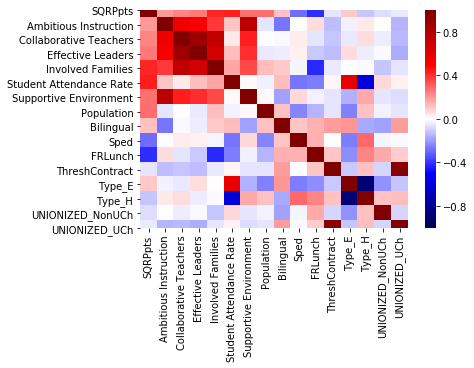

In [25]:
# Let's look for correlations between categories - note high correlation between
# 'Effective Leaders' and 'Collaborative Teachers', as well as 
# UnionizedCharters and ThreshContract(definitionally). Notice that Type of school 
# interfere with each other as well as Student Attendance Rate 
# (only high schoolers skip school)
school_df.corr()
sns.heatmap(sch_df.corr(), cmap="seismic", vmin=-1, vmax=1);

# Model - Feature Selection

Split data into 80/20 train and test split.

When I ran the model on my training data, I noticed that population had a very high p-value and decided to drop it as a feature. The effect of this was my mean R2 on a K-fold cross-validation went up by 0.005.

In addition, 'Collaborative Teachers' shows strong correlation with 'Effective Leaders', so I dropped that to avoid issues with multicollinearity.

The ThreshContract column (# of days with contract at unionized charters) is only relevant for 3-4 schools that unionized recently, and had strong correlation with being a unionized charter school in general (duh), so I dropped it.

In [34]:
X, y = school_df.drop(['Ambitious Instruction','Collaborative Teachers','Population','ThreshContract'],axis=1), school_df['Ambitious Instruction']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=15) #hold out 20% of the data for final testing

In [35]:
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Ambitious Instruction   R-squared (uncentered):                   0.989
Model:                               OLS   Adj. R-squared (uncentered):              0.989
Method:                    Least Squares   F-statistic:                              3391.
Date:                   Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                           15:50:46   Log-Likelihood:                         -1557.7
No. Observations:                    447   AIC:                                      3139.
Df Residuals:                        435   BIC:                                      3189.
Df Model:                             12                                                  
Covariance Type:               nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
SQRPpts                    -0.4055      0.750     -0.541      0.589      -1.879       1.068
Effective Leaders           0.1556      0.037      4.197      0.000       0.083       0.229
Involved Families           0.1629      0.037      4.382      0.000       0.090       0.236
Student Attendance Rate     0.1951      0.052      3.763      0.000       0.093       0.297
Supportive Environment      0.5149      0.026     20.104      0.000       0.465       0.565
Bilingual                 -18.4537      2.690     -6.859      0.000     -23.742     -13.166
Sped                       -5.6044      4.300     -1.303      0.193     -14.056       2.847
FRLunch                    19.5144      2.724      7.164      0.000      14.160      24.868
Type_E                      1.1365      2.115      0.537      0.591      -3.020       5.293
Type_H                     -3.4103      2.149     -1.587      0.113      -7.634       0.813
UNIONIZED_NonUCh            0.8260      1.313      0.629      0.529      -1.754       3.406
UNIONIZED_UCh              -2.4701      1.915     -1.290      0.198      -6.235       1.294
==============================================================================
Omnibus:                        2.546   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.311
Skew:                          -0.142   Prob(JB):                        0.315
Kurtosis:                       3.207   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
#this helps with the way kf will generate indices below
lm = LinearRegression()
Xkf, ykf = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
cross_val_score(lm, Xkf, ykf, cv=kf, scoring='r2').mean()

0.6979457832188516

**High R2train, low R2val**

At this point, my R2-adj is 0.989, but my mean R2 from cross-validiation 0.70. So now it's time to try some regularization, feature engineering, and dropping features.

At a first glance, none of my features seem to clearly resemble polynomial functions in relation to 'Ambitious Instruction.'

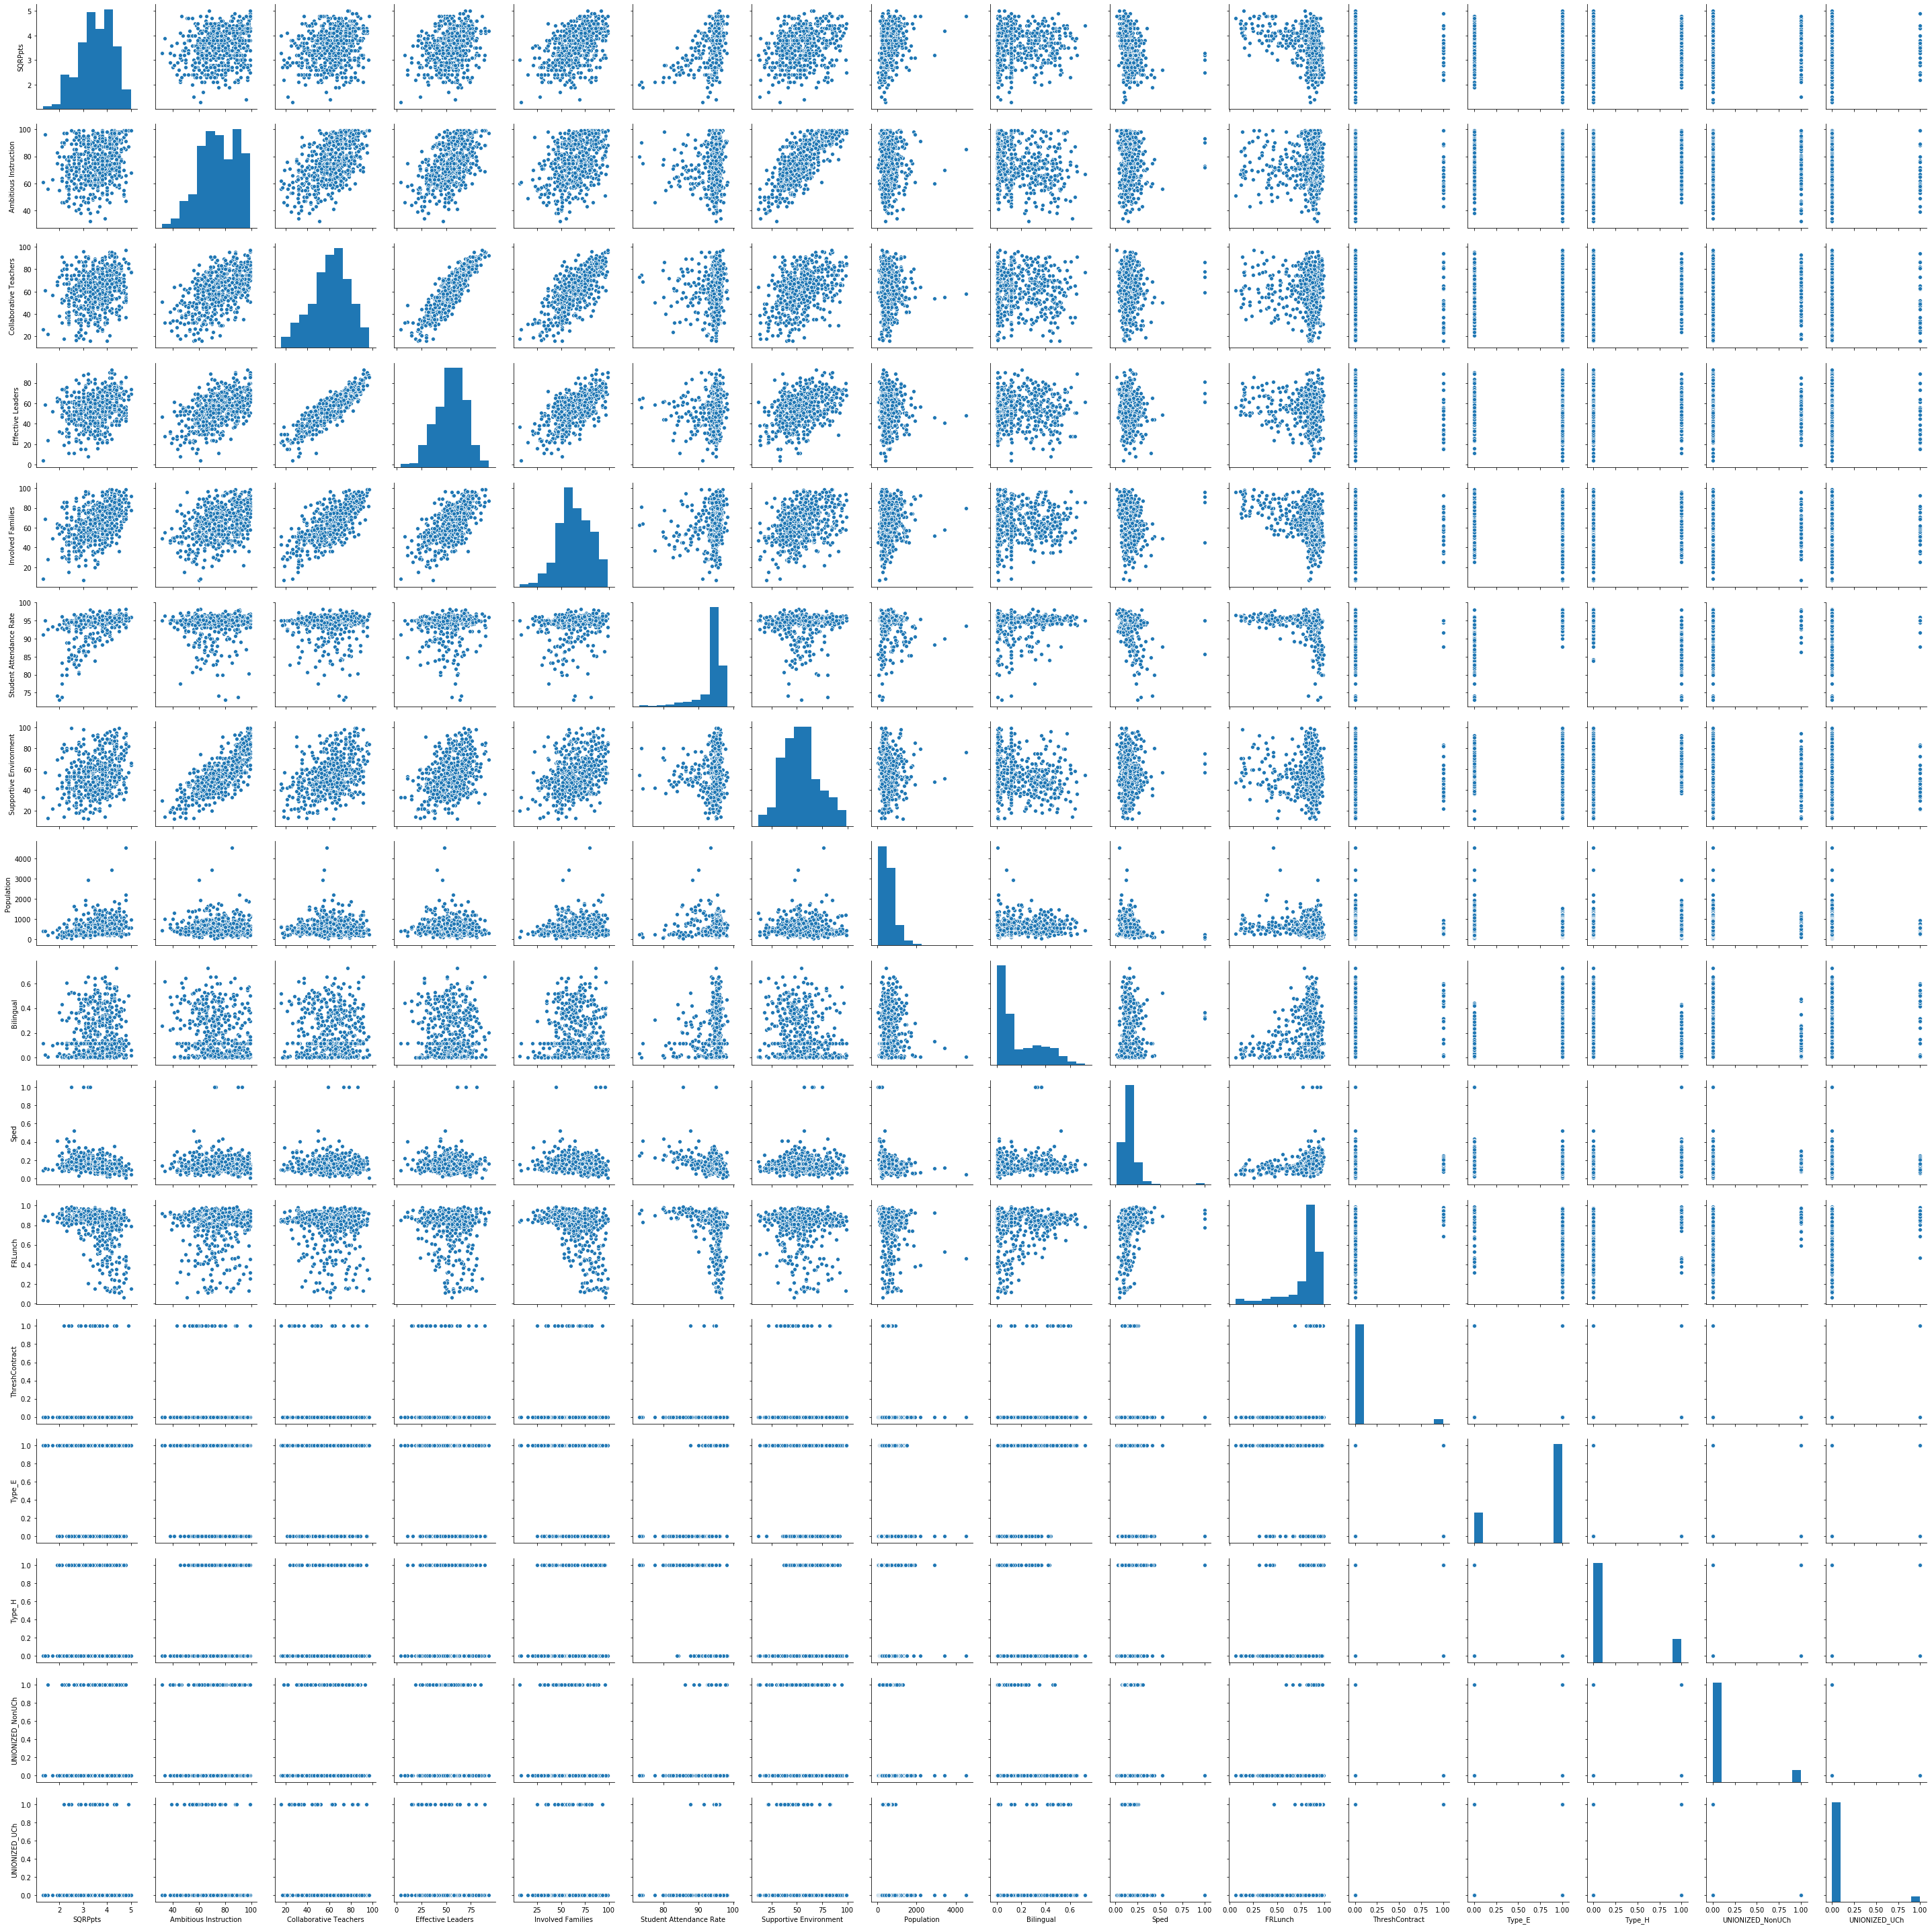

In [39]:
sns.pairplot(school_df)

## LARS-PATH - what features can I lose?

In [40]:
# First scale your X-values for training and testing data
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)

In [41]:
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

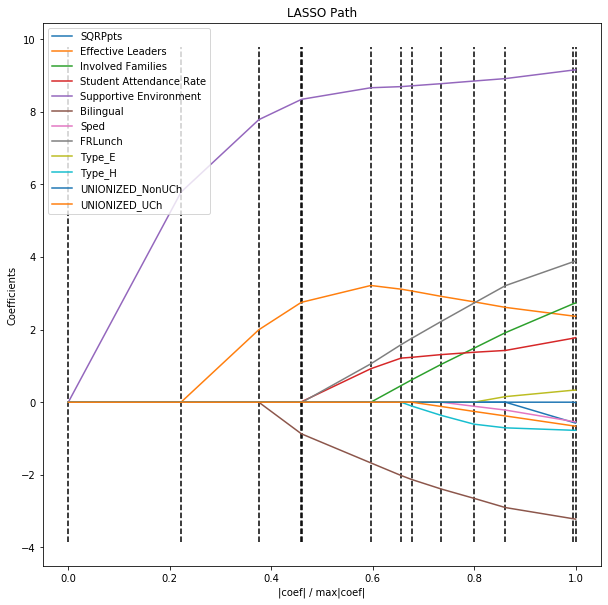

In [42]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns)

plt.show()

It seems like type of school, and being unionized charters/non/CTU or not. Dropping these can seriously cut down on my dummy variables and clean my models. Let's kill them.

I will also drop the variables I saw were not useful and had collinearity issues - population/total and collaborative teachers.

I wonder if CTU or not would have been valuable (versus charter). I decide to put that column in and redo the model

## Simplify union stuff - just do CTU vs charter

In [91]:
# Go back and redo building the dataframe, this time ignoring unionization 
# and just looking at charter vs. not charter
# Repeat all cleaning/renaming from beginning
trimdummies = school_df_smaller.drop(['Type', 'ThreshContract',' Total ','Collaborative Teachers','AvgClassSize','Teacher Retention Rate','Principal Turnover within 6 Years','Student Mobility Rate'],axis=1)
trimdummies.UNIONIZED = trimdummies.UNIONIZED.replace({"NO":"CHARTER",'YES':'CHARTER'})
trimdummies.columns = trimdummies.columns.str.strip()
trimdummies.rename(columns={'Total':'Population'}, inplace=True)
sch_df= pd.get_dummies(trimdummies, drop_first=True)

# Replug in medians for bilingual and SAR
sch_df['Bilingual']=sch_df.Bilingual.fillna(sch_df.Bilingual.median())
sch_df['Student Attendance Rate']=sch_df['Student Attendance Rate'].fillna(sch_df['Student Attendance Rate'].median())

# This dataframe is like before, but no Type and the only dummy variable is CTU/charter
sch_df5= sch_df.dropna()

In [92]:
# Set up my training and testing data. Lose Population and CT because I saw earlier they are not useful features
X, y = sch_df5.drop(['Ambitious Instruction'],axis=1), sch_df5['Ambitious Instruction']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=15) #hold out 20% of the data for final testing

In [93]:
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

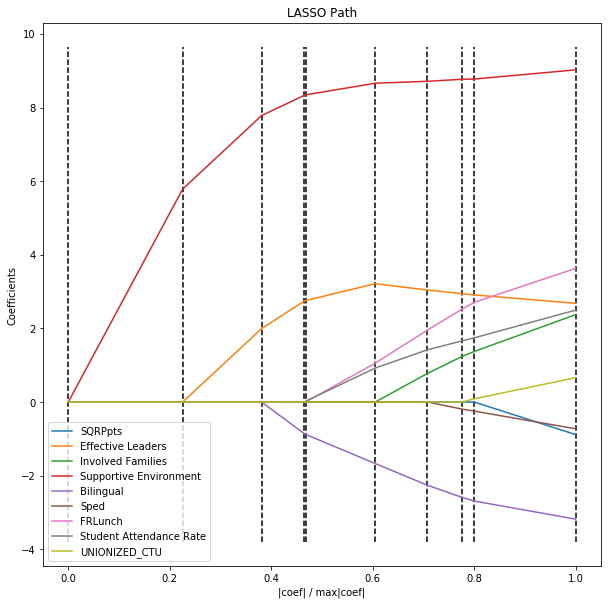

In [94]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns)
plt.savefig("LARS-Path.png",dpi=600)
plt.show()

I still see the same thing - so being a board of ed school vs. charter drops out first, as well as school type and % SpEd. I decide to drop those features and re-cross-validate. SQRPpts also drops out really early, so let's lose that too. 

(At this point, I went ahead and did modeling, but then came back and ultimately decided it was best to lose all the ISBE features that were underreported for charters, except the 2 that seem important for my model - %Bilingual and SAR).

## Simplify more - drop the dummies, the factors with underreported data, and other features with low relevance to model

In [50]:
# Rebuild and reclean dataframe, dropping down to NO D
sch_df=  school_df_smaller.drop(['Type', 'ThreshContract','Population','Sped','SQRPpts','Collaborative Teachers','UNIONIZED','Student Mobility Rate','Teacher Retention Rate','Principal Turnover within 6 Years','AvgClassSize'],axis=1)

sch_df['Bilingual']=sch_df.Bilingual.fillna(sch_df.Bilingual.median())
sch_df['Student Attendance Rate']=sch_df['Student Attendance Rate'].fillna(sch_df['Student Attendance Rate'].median())
sch_df6= sch_df.dropna()

KeyError: "['Student Mobility Rate' 'Teacher Retention Rate'\n 'Principal Turnover within 6 Years' 'AvgClassSize'] not found in axis"

In [ ]:
# Let's pickle this dataframe so I don't have to keep recleaning and plugging medians
with open('schools_finalModelData', 'wb') as to_write:
    pickle.dump(sch_df6, to_write)

In [ ]:
# Redivide my data into a fresh train test split
X, y = sch_df6.drop(['Ambitious Instruction'],axis=1), sch_df6['Ambitious Instruction']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=15) 

In [ ]:
# Do my KFolds cross validation on a plain LinearRegression with these 11 features
Xkf, ykf = np.array(X), np.array(y)
lm=LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 4)
cross_val_score(lm, Xkf, ykf, cv=kf, scoring='r2').mean()

In [ ]:
X.columns

With these 6 features, a linear regression model has a KFoldsCV R2 of 0.696.

This is a lot lower than the training set R2 (0.99). Now I need to start experimenting with other regession types and regularization.

# Model Refinement

## Try to find the best alpha for Ridge

In [ ]:
# Let's find an optimal alpha for my Ridge regression
kf = KFold(n_splits=5, shuffle=True, random_state = 4)

# Make a list of alphas from 0.01 to 100, and a list to hold R2
alphalist = 10**(np.linspace(-2,2,200))
R2_list = []

#Scale my data
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)

# Try out every alpha in the list and save the meanCVR2 score
for i,curr_alpha in enumerate(alphalist):
    lr_model_ridge = Ridge(alpha = curr_alpha)
    lr_model_ridge.fit(X_tr, y)
    R2_list.append(cross_val_score(lr_model_ridge, X_tr, ykf, cv=kf, scoring='r2').mean())

# The best alpha will be the alpha that corresponds to the minimum R2
best_alpha = alphalist[R2_list.index(np.max(R2_list))]
best_alpha

In [ ]:
# Scale my data for training and testing to do a ridge regression
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)

# Look at my Ridge results and input the best alpha from previous loop
lr_model_ridge = Ridge(alpha = 4.5)
lr_model_ridge.fit(X_tr, y)

list(zip(X.columns, lr_model_ridge.coef_))

## Choose between ridge and linear

In [ ]:
# Do side by side comparisons of Ridge and Linear for a bunch of different
# KFold random states - make sure that Ridge is done on scaled, and linear is on 
# unscaled data
randoms = [10, 42, 4, 15,100]

Xkf, ykf = np.array(X_tr), np.array(y)
Xkf_lm = np.array(X)

print("Linear              Ridge")
for seed in randoms:
    kf = KFold(n_splits=5, shuffle=True, random_state = seed)
    print(cross_val_score(lm, Xkf_lm, ykf, cv=kf, scoring='r2').mean(), cross_val_score(lr_model_ridge, Xkf, ykf, cv=kf, scoring='r2').mean())

Trying out both linear and ridge regression model seems to always result in a higher CV score for the Ridge model, so let's stick with that.

Let's try adding a bunch of polynomial terms.

## Try adding polynomial features

In [ ]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_tr)
X_test_poly = poly.transform(X_te)

# Do a lasso to see which features work as 2nd-degree polynomials
lr_model_lasso = Lasso(alpha = 4.5)
lr_model_lasso.fit(X_train_poly, y)

list(zip(X.columns, lr_model_lasso.coef_))

It seems like %bilingual as a 2nd degree polynomial may be a useful term. Let's add that in and rerun the model.

In [130]:
# Create a column with bilingual transformed as a square
sch_df6['BilingualSq']= sch_df6['Bilingual']**2
X, y = sch_df6.drop(['Ambitious Instruction'],axis=1), sch_df6['Ambitious Instruction']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=15) 

# Scale the data for regularization
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)

# Run another Ridge model
lr_model_ridge = Ridge(alpha = 4.5)
lr_model_ridge.fit(X_tr, y)

# Get a KF-CV score from the new Ridge model
Xkf, ykf = np.array(X_tr), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 15)
cross_val_score(lr_model_ridge, Xkf, ykf, cv=kf, scoring='r2').mean()

0.6948813358099033

Well, the CV score is higher (0.6966 at RS15) when we DON'T include the BilingualSq column (0.6949 with BSq at RS15), so let's go back to treating all our terms as non-polynomials. 

## Go back to best model so far

In [131]:
# Create a column with bilingual transformed as a square
X, y = sch_df6.drop(['Ambitious Instruction'],axis=1), sch_df6['Ambitious Instruction']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=15) 

# Scale the data for regularization
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)
X_te = std.transform(X_test.values)

# Run another Ridge model
lr_model_ridge = Ridge(alpha = 4.5)
lr_model_ridge.fit(X_tr, y)

# Get a KF-CV score from the new Ridge model
Xkf, ykf = np.array(X_tr), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 15)
cross_val_score(lr_model_ridge, Xkf, ykf, cv=kf, scoring='r2').mean()

0.6948813358099033

## Testing and Calculating Error

In [132]:
lr_model_ridge.score(X_te,y_test)

0.7052528506718876

In [133]:
# import model and fit
from sklearn.metrics import mean_squared_error 

predict = lr_model_ridge.predict(X_te)
rmse = np.sqrt(((predict-y_test)**2).mean())

In [134]:
rmse

7.268292040559648

## Check Assumptions - Plot Residuals

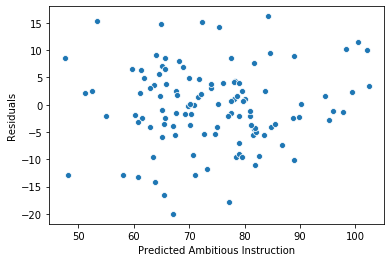

In [135]:
resid = sns.scatterplot(x=predict,y=(predict-y_test))
resid.set(xlabel='Predicted Ambitious Instruction', ylabel='Residuals')
plt.savefig("residualsvgpredict.png",dpi=1200)
plt.show()


In [ ]:
# Make my Q-Q plot to verify that my residuals have a normal distribtuions
import scipy.stats as stats
res = predict-y_test
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.savefig("QQplotres.png",dpi=600)

## Test out model on a school I know

In [ ]:
# Grab the data from my old school, BOYCP
X.loc[400053]

In [ ]:
# Make my school's data into an array and scale it, then try 
# plugging in different values to see what could improve teaching
boycp = np.array([40,67,73,0.111,0.957,95.1])
boycp = boycp.reshape(1,-1)
boycp_tr = std.transform(boycp)
lr_model_ridge.predict(boycp_tr.reshape(1,-1))

In [ ]:
# This figure is just for my appendix
sch_df6.corr()
sns.heatmap(sch_df6.corr(),cmap='seismic')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("correlations.png",dpi=600)